# Информация технического характера:
- инструментарий...
- данные...

In [1]:
import pandas as pd
import numpy as np
import scipy as st
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (cross_val_score, RandomizedSearchCV, train_test_split)

from sklearn.metrics import (accuracy_score, make_scorer, mean_absolute_error)
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer

from collections import Counter
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor


In [2]:
# по совету наставников изменим индекс на дату
# так периодичность замеров линейная - это сильно упростит дальнейшую работу

try:
    data_train = pd.read_csv('/Users/a1234/Documents/vscode-projects/projects_yandex/final_fight/gold_recovery_train_new.csv', index_col='date', parse_dates=True)
    data_full = pd.read_csv('/Users/a1234/Documents/vscode-projects/projects_yandex/final_fight/gold_recovery_full_new.csv', index_col='date', parse_dates=True)
    data_test = pd.read_csv('/Users/a1234/Documents/vscode-projects/projects_yandex/final_fight/gold_recovery_test_new.csv', index_col='date', parse_dates=True)
except:
    data_train = pd.read_csv('/datasets/gold_recovery_train_new.csv', index_col='date', parse_dates=True)
    data_test = pd.read_csv('/datasets/gold_recovery_test_new.csv', index_col='date', parse_dates=True)
    data_full = pd.read_csv('/datasets/gold_recovery_full_new.csv', index_col='date', parse_dates=True)

# Подготовка прототипа модели ML для разработки решения эффективной работы промышленных предприятий.

### Техническое требование к исследованию:
- требуется модель способная предсказывать коэффицент золота из золотосодержащей руды

### Характер предоставленных данных:
- параметры добычи и очистки руды/металла

### Актуальность и область применения модели:
- оптимизация производства
- анализ прибыльности
- поиск рецептуры

### Ход работы:
1. подготовка данных
2. исследовательский анализ данных
3. построение и обучение моделей
4. выводы

# Подготовка полученных данных

### Тирражируемая функция предварительной проверки.

In [3]:
def check_data(data_df):
        print ('\033[1m' + 'Изучим исходные данные'+ '\033[0m')
        print(data_df.info())
            
        missed_cells = data_df.isnull().sum().sum()/(data_df.shape[0]*(data_df.shape[1]-1))
        missed_rows = sum(data_df.isnull().sum(axis = 1)>0)/data_df.shape[0]
        print ('\033[1m' + '\nПроверка пропусков'+ '\033[0m')
        print ('Количество пропусков: {:.0f}'.format(data_df.isnull().sum().sum()))
        print ('Доля пропусков: {:.1%}'.format(missed_cells)+ '\033[0m')
        print ('Доля строк содержащих пропуски: {:.1%}'.format(missed_rows))
        
        display(pd.DataFrame(
        np.array([data_df.isna().sum(), data_df.isna().mean()]).T, 
        columns=['missing_sum', 'missing_mean'],
        index=data_df.columns))

        ## Проверим дубликаты
        print ('\033[1m' + '\nПроверка на дубликаты'+ '\033[0m')
        print('Количество полных дубликатов: ', data_df.duplicated().sum())
            
        ## Посмотрим на сами данные
        print ('\033[1m' + '\nПервые пять строк датасета'+ '\033[0m')
        display(data_df.head())

        print('\033[1m' + '\nОписание количественных данных:'+ '\033[0m')
        display(data_df.describe().T)
        
        # кусок хункции от Гуру аналитики! (сохранен на будущее)
        
        # print('\033[1m' + '\nОписание категориальных данных:'+ '\033[0m')
        # display(data_df.describe(include='object').T) 
        
        
        # print('\033[1m' + '\nВывод уникальных значений по каждому категориаьному признаку:'+ '\033[0m')    
        # df_object = data_df.select_dtypes(include='object').columns
        
        # for i in df_object:
        #     print('\033[1m' + '_'+ str(i) + '\033[0m')
        #     display(data_df[i].value_counts())

#### **data_full**

In [4]:
check_data(data_full)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         19438 non-null  float64
 1   final.output.concentrate_pb                         19438 non-null  float64
 2   final.output.concentrate_sol                        19228 non-null  float64
 3   final.output.concentrate_au                         19439 non-null  float64
 4   final.output.recovery                               19439 non-null  float64
 5   final.output.tail_ag                                19438 non-null  float64
 6   final.output.tail_pb                                19338 non-null  float64
 7   final.output.tail_sol                               19433 non-null  float64
 8   final.output.tail_

,missing_sum,missing_mean
final.output.concentrate_ag,1.0,0.000051
final.output.concentrate_pb,1.0,0.000051
final.output.concentrate_sol,211.0,0.010854
final.output.concentrate_au,0.0,0.000000
final.output.recovery,0.0,0.000000
...,...,...
secondary_cleaner.state.floatbank5_a_level,1.0,0.000051
secondary_cleaner.state.floatbank5_b_air,1.0,0.000051
secondary_cleaner.state.floatbank5_b_level,1.0,0.000051
secondary_cleaner.state.floatbank6_a_air,2.0,0.000103



Проверка на дубликаты
Количество полных дубликатов:  0

Первые пять строк датасета


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691



Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
final.output.concentrate_ag,19438.0,5.168470,1.372348,0.000000,4.251240,5.066094,5.895527,16.001945
final.output.concentrate_pb,19438.0,9.978895,1.669240,0.000000,9.137262,10.102433,11.035769,17.031899
final.output.concentrate_sol,19228.0,9.501224,2.787537,0.000000,7.722820,9.218961,10.947813,19.615720
final.output.concentrate_au,19439.0,44.076513,5.129784,0.000000,43.402215,45.011244,46.275313,52.756638
final.output.recovery,19439.0,67.050208,10.125840,0.000000,63.299712,68.172738,72.686642,100.000000
...,...,...,...,...,...,...,...,...
secondary_cleaner.state.floatbank5_a_level,19438.0,-488.684065,34.533396,-797.323986,-500.458467,-499.802605,-498.384187,-244.483566
secondary_cleaner.state.floatbank5_b_air,19438.0,12.198224,5.333024,0.528083,8.971105,11.019433,14.019088,27.926001
secondary_cleaner.state.floatbank5_b_level,19438.0,-487.149827,38.347312,-800.220337,-500.129462,-499.935317,-499.436708,-137.740004
secondary_cleaner.state.floatbank6_a_air,19437.0,18.959024,5.550498,-0.079426,14.983037,19.960541,24.003170,32.188906


**Вывод:**
- **19439** наблюдений
- **86** признаков
- доля пропусков от общего пула значений **0.3%**

#### **data_train**

In [5]:
check_data(data_train)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14148 non-null  float64
 1   final.output.concentrate_pb                         14148 non-null  float64
 2   final.output.concentrate_sol                        13938 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14049 non-null  float64
 7   final.output.tail_sol                               14144 non-null  float64
 8   final.output.tail_

,missing_sum,missing_mean
final.output.concentrate_ag,1.0,0.000071
final.output.concentrate_pb,1.0,0.000071
final.output.concentrate_sol,211.0,0.014913
final.output.concentrate_au,0.0,0.000000
final.output.recovery,0.0,0.000000
...,...,...
secondary_cleaner.state.floatbank5_a_level,1.0,0.000071
secondary_cleaner.state.floatbank5_b_air,1.0,0.000071
secondary_cleaner.state.floatbank5_b_level,1.0,0.000071
secondary_cleaner.state.floatbank6_a_air,2.0,0.000141



Проверка на дубликаты
Количество полных дубликатов:  0

Первые пять строк датасета


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691



Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
final.output.concentrate_ag,14148.0,5.142034,1.369586,0.000000,4.211620,4.994652,5.859540,16.001945
final.output.concentrate_pb,14148.0,10.132960,1.654930,0.000000,9.297355,10.297144,11.170603,17.031899
final.output.concentrate_sol,13938.0,9.202849,2.790516,0.000000,7.484645,8.845462,10.487508,18.124851
final.output.concentrate_au,14149.0,44.003792,4.905261,0.000000,43.276111,44.872436,46.166425,52.756638
final.output.recovery,14149.0,66.518832,10.295402,0.000000,62.545817,67.432775,72.346428,100.000000
...,...,...,...,...,...,...,...,...
secondary_cleaner.state.floatbank5_a_level,14148.0,-483.956022,37.892788,-797.142475,-500.363177,-499.702452,-487.712108,-275.073125
secondary_cleaner.state.floatbank5_b_air,14148.0,13.064590,5.765617,0.646208,8.994405,11.997547,17.982903,27.926001
secondary_cleaner.state.floatbank5_b_level,14148.0,-483.966564,39.207913,-800.006180,-500.105994,-499.914556,-453.186936,-157.396071
secondary_cleaner.state.floatbank6_a_air,14147.0,19.577539,5.764417,0.195324,14.989304,19.984175,24.991623,32.188906


**Вывод:**
- **14149** наблюдений
- **86** признаков
- доля пропусков от общего пула значений **0.3%**

#### **data_test**

In [6]:
check_data(data_test)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5286 non-null   float64
 1   primary_cleaner.input.depressant            5285 non-null   float64
 2   primary_cleaner.input.feed_size             5290 non-null   float64
 3   primary_cleaner.input.xanthate              5286 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 9   primary_cleaner.state.floa

,missing_sum,missing_mean
primary_cleaner.input.sulfate,4.0,0.000756
primary_cleaner.input.depressant,5.0,0.000945
primary_cleaner.input.feed_size,0.0,0.000000
primary_cleaner.input.xanthate,4.0,0.000756
primary_cleaner.state.floatbank8_a_air,0.0,0.000000
primary_cleaner.state.floatbank8_a_level,0.0,0.000000
primary_cleaner.state.floatbank8_b_air,0.0,0.000000
primary_cleaner.state.floatbank8_b_level,0.0,0.000000
primary_cleaner.state.floatbank8_c_air,0.0,0.000000
primary_cleaner.state.floatbank8_c_level,0.0,0.000000



Проверка на дубликаты
Количество полных дубликатов:  0

Первые пять строк датасета


,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,-500.810606,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333



Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
primary_cleaner.input.sulfate,5286.0,174.839652,43.027080,2.566156e+00,147.121401,177.828489,208.125438,265.983123
primary_cleaner.input.depressant,5285.0,8.683596,3.072050,3.839482e-03,6.489555,8.052207,10.027764,40.000000
primary_cleaner.input.feed_size,5290.0,7.266339,0.610219,5.650000e+00,6.890000,7.250000,7.600000,15.500000
primary_cleaner.input.xanthate,5286.0,1.383803,0.643474,4.983673e-03,0.907623,1.197610,1.797819,4.102454
primary_cleaner.state.floatbank8_a_air,5290.0,1539.494325,116.797884,5.445860e-32,1498.935802,1585.129123,1602.076529,2103.103580
primary_cleaner.state.floatbank8_a_level,5290.0,-497.665883,19.952431,-7.953163e+02,-500.357298,-499.969164,-499.568951,-57.195404
primary_cleaner.state.floatbank8_b_air,5290.0,1545.174232,122.224588,6.647490e-32,1498.970993,1595.621798,1602.323545,1813.083671
primary_cleaner.state.floatbank8_b_level,5290.0,-500.273098,32.968307,-7.999970e+02,-500.703002,-500.028514,-499.293257,-142.527229
primary_cleaner.state.floatbank8_c_air,5290.0,1527.272362,122.538034,4.033736e-32,1473.229862,1549.594682,1601.143775,1715.053773
primary_cleaner.state.floatbank8_c_level,5290.0,-498.330680,21.964876,-7.999606e+02,-501.018117,-500.017711,-498.994130,-150.937035


**Вывод:**
- **5290** наблюдений
- **86** признаков
- доля пропусков от общего пула значений **0.0%**

### Проверка корректности расчета эффективности обогащения

In [7]:
C = data_train['rougher.output.concentrate_au']
F = data_train['rougher.input.feed_au']
T = data_train['rougher.output.tail_au']

recovery_t = data_train['rougher.output.recovery']
recovery = (C * (F - T)) / (F * (C - T)) * 100

# средняя абсолютная ошибка между величинами
MAE = (abs(recovery - recovery_t)).sum() / len (recovery)
print(f'Средняя абсолютная ошибка между величинами ({MAE:.15f})')

Средняя абсолютная ошибка между величинами (0.000000000000010)


**Число стремится к нулю, расчет подтвержден.**

### Анализ признаков в выборках.

По ЛОРу тестовая выборка постепенно пополняется значениями.\
В обучении модели мы можем использовать признаки присутствующие\
в каждой выборке. Отберем нужные поля.

In [8]:
print(len(data_train.columns))
data_train.columns

86


Index(['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state

In [9]:
print(len(data_test.columns))
data_test.columns

52


Index(['primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'rougher.state.floatba

In [10]:
col_not_test = set(data_train.columns) - set(data_test.columns)
print(f'Количество элементов {len(col_not_test)}')

Количество элементов 34


## Предобработка данных

### Проверка на монотонность

In [11]:
print(f'''
Монотонность полной выборки - ({data_full.index.is_monotonic_increasing})
Монотонность тренировочной выборки - ({data_train.index.is_monotonic_increasing})
Монотонность тестовой выборки - ({data_test.index.is_monotonic_increasing})
''')


Монотонность полной выборки - (True)
Монотонность тренировочной выборки - (True)
Монотонность тестовой выборки - (True)



#### Заполнение пропусков

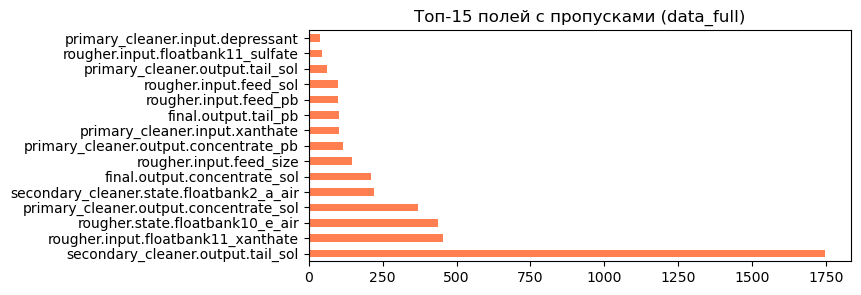

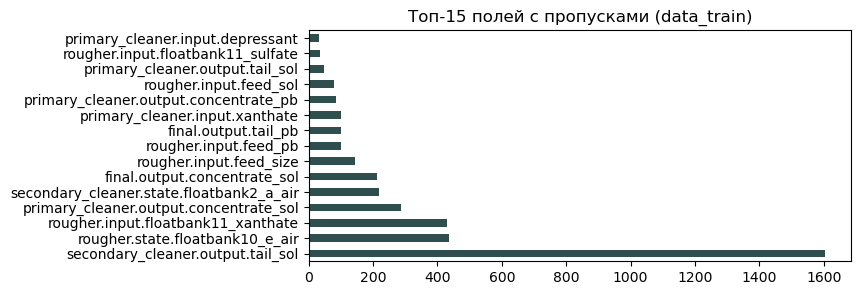

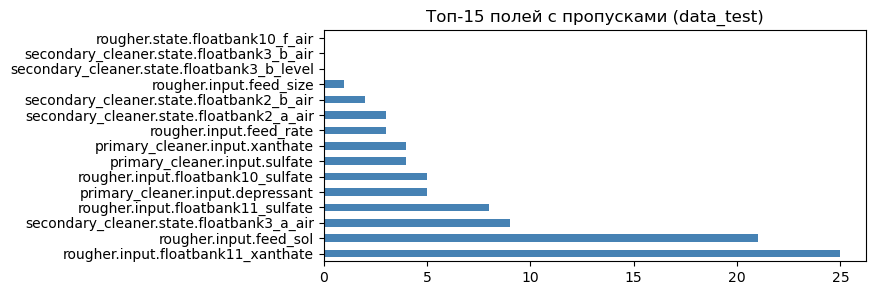

In [12]:
data_full.isnull().sum().sort_values(ascending=False).head(15).plot(
                                    kind='barh',
                                    figsize=(7, 3),
                                    color='coral',
                                    title='Топ-15 полей с пропусками (data_full)')
plt.show()

data_train.isnull().sum().sort_values(ascending=False).head(15).plot(
                                    kind='barh',
                                    figsize=(7, 3),
                                    color='darkslategrey',
                                    title='Топ-15 полей с пропусками (data_train)')
plt.show()

data_test.isnull().sum().sort_values(ascending=False).head(15).plot(
                                    kind='barh',
                                    figsize=(7, 3),
                                    color='steelblue',
                                    title='Топ-15 полей с пропусками (data_test)')
plt.show()

Ввиду того, что трек обучения ML выбранный метод заполнения пропусков основан на ML.

UPD: к сожалению, от идеии пришлось отказаться. По какой-то из причин,\
ML заполнил данные в формате не пригодном для дальнейшей работы. Буду разбираться

UPD 2: похоже, я пытался заполнить пропуски средним значением. Только не забрался,\
метод вычисляет среднее для поля или всего фрейма. Код остается в комментарии для,\
как памятник коварности методов и функций.

Выбран метод интерполяции данных, вввиду того, что монотонность показала себя отлично

In [13]:
# data_full = SimpleImputer(strategy='mean').fit_transform(data_full)
# data_train = SimpleImputer(strategy='mean').fit_transform(data_train)
# data_test = SimpleImputer(strategy='mean').fit_transform(data_test)

data_full = data_full.interpolate(method='linear')
data_train = data_train.interpolate(method='linear')
data_test = data_test.interpolate(method='linear')

# data_full.dropna(inplace=True)
# data_train.dropna(inplace=True)
# data_test.dropna(inplace=True)

In [14]:
print(f'''
Кол-во нулевых значений data_full: {data_full.isna().sum().sum()}
Кол-во нулевых значений data_train: {data_train.isna().sum().sum()}
Кол-во нулевых значений data_test: {data_test.isna().sum().sum()}''')


Кол-во нулевых значений data_full: 0
Кол-во нулевых значений data_train: 0
Кол-во нулевых значений data_test: 0


**Успех. Датасет успешно заполнен.**

## Изменение концентрации металлов на каждом из этапов

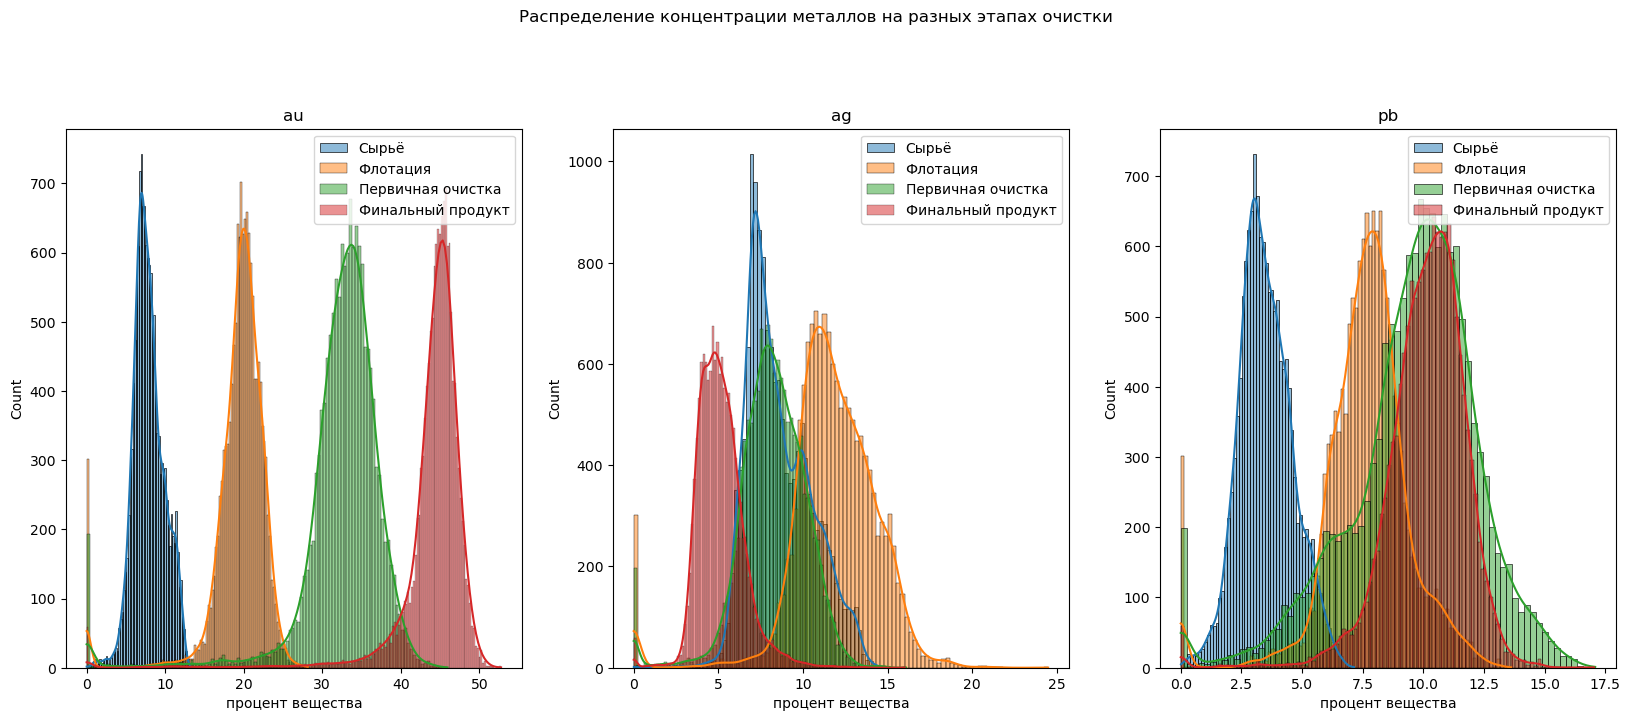

In [15]:
def graph_concentration(df, metals):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 7))
    
    for i, metal in enumerate(metals):
        ax = axes[i]
        
        sns.histplot(df[f'rougher.input.feed_{metal}'], label='Сырьё', kde=True, ax=ax)
        sns.histplot(df[f'rougher.output.concentrate_{metal}'], label='Флотация', kde=True, ax=ax)
        sns.histplot(df[f'primary_cleaner.output.concentrate_{metal}'], label='Первичная очистка', kde=True, ax=ax)
        sns.histplot(df[f'final.output.concentrate_{metal}'], label='Финальный продукт', kde=True, ax=ax)
        
        ax.set_title(f'{metal}')
        ax.set_xlabel('процент вещества')
        ax.legend()

    fig.suptitle('Распределение концентрации металлов на разных этапах очистки', y=1.05)
    plt.show()

graph_concentration(data_train, ['au', 'ag', 'pb'])

#### **Выводы:**
- *Золото:*

    - концентрация золота увеличивается
    - присутствуют нулевые концентрации
- *Серебро:*

    - концентрация продолжается первые 2 этапа
    - после сильно снижается
    - присутствуют нулевые концентрации
- *Свинец:*

    - превые 3 этапа концентрация свинца увеличивается
    - на финальной стадии стабилизируется
    - присутствуют нулевые концентрации

### Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках

Есть два признака, содержащие размер гранул: 'rougher.input.feed_size'\
и 'primary_cleaner.input.feed_size', гранулы сырья — это 'rougher.input.feed_size'.\
Также t-тестированием проверим нулевую гипотезу о равных средних значениях.

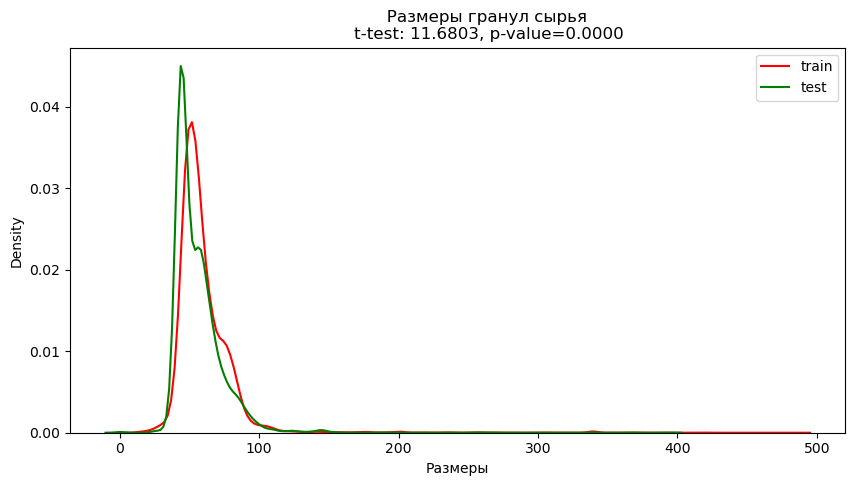

In [16]:
stat, p_value = ttest_ind(
    data_train['rougher.input.feed_size'], 
    data_test['rougher.input.feed_size'])
    

fig, ax = plt.subplots(figsize=(10, 5))
sns.kdeplot(data_train['rougher.input.feed_size'], color='red')
sns.kdeplot(data_test['rougher.input.feed_size'], color='green')
ax.set_xlabel('Размеры')
ax.set_title(f'''           Размеры гранул сырья
            t-test: {stat:.4f}, p-value={p_value:.4f}''')
ax.legend(['train', 'test'])
plt.show()

#### **Вывод:**
Тестовая выборка непригодля для проверки работы линейной модели. Путь решения:\
использовать другие модели ML.

### Суммарная концентрация вещества
Нулевые концентрации - бесполезны. Изучим их. Избавимся

Количество строк после обработки 13725


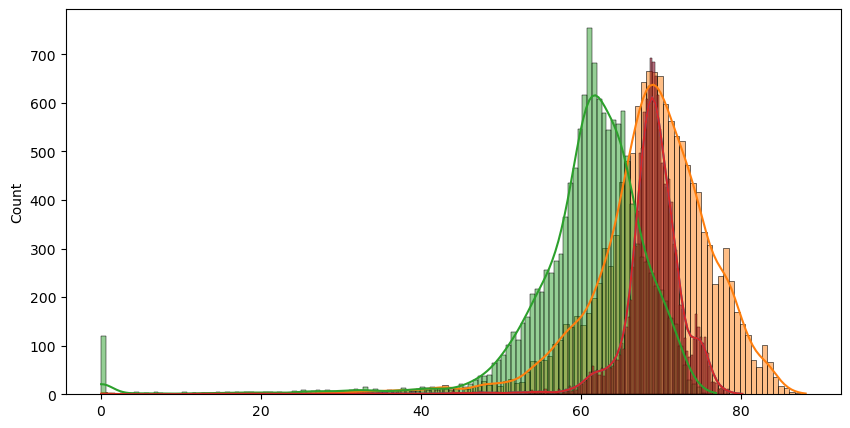

In [17]:
NUM = .005


sum_input_concentrate = [
    'rougher.input.feed_au',
    'rougher.input.feed_ag',
    'rougher.input.feed_pb',
    'rougher.input.feed_sol',
]
sum_rough_concentrate = [
    'rougher.output.concentrate_au',
    'rougher.output.concentrate_ag',
    'rougher.output.concentrate_pb',
    'rougher.output.concentrate_sol',
]
sum_prim_concentrate = [
    'primary_cleaner.output.concentrate_au',
    'primary_cleaner.output.concentrate_ag',
    'primary_cleaner.output.concentrate_pb',
    'primary_cleaner.output.concentrate_sol',
]
sum_final_concentrate = [
    'final.output.concentrate_au',
    'final.output.concentrate_ag',
    'final.output.concentrate_pb',
    'final.output.concentrate_sol',
]

data_train = data_train[data_train[sum_input_concentrate].sum(1) > NUM]
data_train = data_train[data_train[sum_rough_concentrate].sum(1) > NUM]
data_train = data_train[data_train[sum_prim_concentrate].sum(1) > NUM]
data_train = data_train[data_train[sum_final_concentrate].sum(1) > NUM]

# графическое представление характера данных
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data_train[sum_final_concentrate].sum(1), kde=True);
sns.histplot(data_train[sum_rough_concentrate].sum(1), kde=True);
sns.histplot(data_train[sum_prim_concentrate].sum(1), kde=True);
sns.histplot(data_train[sum_final_concentrate].sum(1), kde=True);

print(f'Количество строк после обработки {data_train.shape[0]}')

del NUM

## Подготовка данных
Перед построением моделей избавимся от мультиколлинеарных значений, а также приведем\
в соответствие тестовой тренировочную выборку, исключив нецелевые признаки.

In [18]:
col_not_test = set(data_train.columns) - set(data_test.columns)
col_not_test -= {'rougher.output.recovery', 'final.output.recovery'}
data_train = data_train.drop(col_not_test, axis=1)

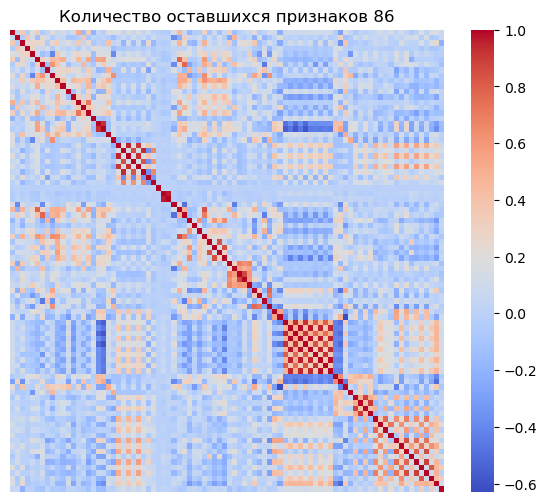

In [19]:
NUM = .8
 # задай корреляцию

# проверка признаков на корреляцию. это готовое решение
corr = data_train.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1).corr()
corr_s = corr.unstack()
high_corr = dict()

for el in corr_s.index:
    if el[0] != el[1] and abs(corr_s[el]) >= NUM:
        high_corr[tuple(sorted(list(el)))] = corr_s[el]

features_to_drop = []

while high_corr:
    features_freq = [
    (k, v) for k, v in sorted(
        Counter(
            [el for pair in high_corr.keys() for el in pair]
        ).items(), key=lambda item: item[1])
    ]
    features_to_drop.append(features_freq[-1][0])
    features_freq = features_freq[:-1]
    keys_drop = [key for key in high_corr.keys() if features_to_drop[-1] in key]
    for k in keys_drop:
        del high_corr[k]
        
data_train = data_train.drop(features_to_drop, axis=1)
data_test = data_test.drop(features_to_drop, axis=1)

plt.figure(figsize=(7, 6))
sns.heatmap(data_full.corr(), cmap='coolwarm')
plt.title(f'Количество оставшихся признаков {data_full.shape[1]}')
plt.axis('off')
plt.show();

In [20]:
# тренировочные входные признаки 
X_train = data_train.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1).reset_index(drop=True)

y_train_rougher = data_train['rougher.output.recovery'].reset_index(drop=True)
y_train_final = data_train['final.output.recovery'].reset_index(drop=True)

X_train.shape, y_train_rougher.shape, y_train_final.shape

((13725, 34), (13725,), (13725,))

In [21]:
# тестовые входные признаки 
X_test = data_test.copy()

y_test_rougher = data_full['rougher.output.recovery'].loc[data_test.index].reset_index(drop=True)
y_test_final = data_full['final.output.recovery'].loc[data_test.index].reset_index(drop=True)

X_test.shape, y_test_rougher.shape, y_test_final.shape

((5290, 34), (5290,), (5290,))

### Модели
Функции для расчета sMAPE и итоговое sMAPE

In [22]:
def smape(y_true, y_pred):
    error = np.abs(y_true - y_pred)
    scale = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(error / scale) * 100

def smape_final(smape_rougher, smape_final):
    return 0.25 * smape_rougher + 0.75 * smape_final

scorer = make_scorer(smape, greater_is_better=False)

Функции симметричной средней абсолютной процентной ошибки готовы.

## Построение моделей, обкатка

### Линейная регрессия

Все же построим модель. Масштабируем признаки

In [23]:
scaler = StandardScaler()
features_train_lr = scaler.fit_transform(X_train)
features_test_lr = scaler.transform(X_test)

model_lr = LinearRegression(n_jobs=-1)
score_rougher_lr = -1 * cross_val_score( model_lr, features_train_lr, y_train_rougher, scoring=scorer, n_jobs=-1).mean()
print(f'Значение SMAPE для rougher на кросс-валидации: {score_rougher_lr}')

score_final_lr = -1 * cross_val_score(model_lr, features_train_lr, y_train_final, scoring=scorer, n_jobs=-1).mean()
print(f'Значение SMAPE для final: {score_final_lr}')

Значение SMAPE для rougher на кросс-валидации: 6.384815765896707
Значение SMAPE для final: 10.185811562568343


#### Вывод:
Достачно большие показатели, что мы предсказывали, глядя на граффик сравнения зернистости.

### Деревья

In [24]:
decision_tree_model = DecisionTreeRegressor()

decision_parameters = {
              "max_depth": range(3, 7),
              "min_samples_leaf": range(3, 8)}

decision_grid =  RandomizedSearchCV(estimator=decision_tree_model, param_distributions=decision_parameters, \
                                    cv=3,scoring=scorer, n_iter = 20)
decision_grid.fit(X_train, y_train_rougher)
print(f'Гиперпараметры лучшей модели: {decision_grid.best_params_}') 
print(f'Значение SMAPE для rougher: {-1 * decision_grid.best_score_}')

decision_grid =  RandomizedSearchCV(estimator=decision_tree_model, param_distributions=decision_parameters, \
                                    cv=3,scoring=scorer, n_iter = 20)
decision_grid.fit(X_train, y_train_final)
print(f'Гиперпараметры лучшей модели: {decision_grid.best_params_}') 
print(f'Значение SMAPE для final: {-1 * decision_grid.best_score_}')

Гиперпараметры лучшей модели: {'min_samples_leaf': 3, 'max_depth': 6}
Значение SMAPE для rougher: 7.66387893935251
Гиперпараметры лучшей модели: {'min_samples_leaf': 3, 'max_depth': 6}
Значение SMAPE для final: 11.55425249119945


#### Выводы:

Деревья показали себя хуже. Думаю, случайный лес покажет более устойчивый и обощающий результат.

### Случайный лес

In [25]:
model_rfr = RandomForestRegressor(n_jobs=-1, random_state=12345)
params={
    'max_depth': (None, *range(5, 9)), 
    'min_samples_split': range(6, 9),
    'min_samples_leaf': range(2, 5)
}
rfr_rougher = RandomizedSearchCV(
    model_rfr, 
    params, 
    scoring=scorer, 
    n_jobs=-1, 
    random_state=12345
    
)
rfr_rougher.fit(X_train, y_train_rougher)
print(f'Гиперпараметры лучшей модели: {rfr_rougher.best_params_}') 
print(f'Значение SMAPE для rougher: {-1 * rfr_rougher.best_score_}') 

rfr_final = RandomizedSearchCV(
    model_rfr, 
    params, 
    scoring=scorer, 
    n_jobs=-1, 
    random_state=12345
)

rfr_final.fit(X_train, y_train_final)
print(f'Гиперпараметры лучшей модели: {rfr_final.best_params_}') 
print(f'Значение SMAPE: {-1 * rfr_final.best_score_}') 

Гиперпараметры лучшей модели: {'min_samples_split': 6, 'min_samples_leaf': 3, 'max_depth': 5}
Значение SMAPE для rougher: 6.4566275851738295
Гиперпараметры лучшей модели: {'min_samples_split': 8, 'min_samples_leaf': 4, 'max_depth': 6}
Значение SMAPE: 8.825688077821255


#### Выводы:
Гиперпарамтры получены, процентное отклонение определено поэтапно.\
Показатели симметричной средней абсолютной процентной ошибки низкие

### Сравнительный анализ моделей. Выбор лучшей

На раннем этапе было принято отказаться от линейных моделей,\
и все же для более полного анализа модель добавлена.

In [26]:
models = [LinearRegression(),
        DecisionTreeRegressor(random_state = 12345), 
        RandomForestRegressor(random_state = 12345)]


results_cross_val = []

for model in models: 
    
    scorer = make_scorer(smape, greater_is_better=False) 
    
    cross_val_score_rougher = cross_val_score(model, X_train, y_train_rougher,
                                              cv=3, scoring=scorer).mean()
    cross_val_score_final = cross_val_score(model, X_train, y_train_final,
                                            cv=3, scoring=scorer).mean()

    results_cross_val.append({'model name': model.__class__.__name__, 
                              'cross_val_score_rougher': cross_val_score_rougher, 
                              'cross_val_score_final': cross_val_score_final}) 
              
pd.DataFrame(results_cross_val)

,model name,cross_val_score_rougher,cross_val_score_final
0,LinearRegression,-8.637448,-11.158662
1,DecisionTreeRegressor,-8.359899,-17.705380
2,RandomForestRegressor,-7.796111,-10.533761


#### Выводы:

Выбор очевиден.\
Как можем заметить, надежнее остальных модель случайного леса\
с заданными гиперпараметрами.

#### Дополнительная проверка случайного леса в "ручном режиме"

In [27]:
results = []

for depth in range(2,4):
    for estimator in range(10, 21, 5):
        
        model = RandomForestRegressor(random_state=12345, 
                                       n_estimators=estimator, 
                                       max_depth=depth)
        
        scorer = make_scorer(smape, greater_is_better=False) 
    
        cross_val_score_rougher = cross_val_score(model, X_train, y_train_rougher, cv=3, scoring=scorer).mean()
        cross_val_score_final = cross_val_score(model, X_train, y_train_final, cv=3, scoring=scorer).mean() 

        results.append({'model name': model.__class__.__name__, 
                        'Hyperparameters': {'random_state': 12345, 
                                            'n_estimators': estimator, 
                                            'max_depth':depth}, 
                        'score_rougher': cross_val_score_rougher,
                        'score_final': cross_val_score_final})
        
pd.DataFrame(results)

,model name,Hyperparameters,score_rougher,score_final
0,RandomForestRegressor,"{'random_state': 12345, 'n_estimators': 10, 'm...",-7.772188,-10.464832
1,RandomForestRegressor,"{'random_state': 12345, 'n_estimators': 15, 'm...",-7.789457,-10.401257
2,RandomForestRegressor,"{'random_state': 12345, 'n_estimators': 20, 'm...",-7.908137,-10.272530
3,RandomForestRegressor,"{'random_state': 12345, 'n_estimators': 10, 'm...",-7.948624,-10.916927
4,RandomForestRegressor,"{'random_state': 12345, 'n_estimators': 15, 'm...",-7.938525,-11.026668
5,RandomForestRegressor,"{'random_state': 12345, 'n_estimators': 20, 'm...",-8.001696,-11.001457


Результат подтвержден.

## Проверка моделей на тестовых выборках

In [28]:
predict_final = rfr_final.predict(X_test)
smap_final = smape(y_test_final, predict_final)
print(f'final, SMAPE: {round(smap_final, 2)}')

predict_rougher = rfr_rougher.predict(X_test)
smap_rougher = smape(y_test_rougher, predict_rougher)
print(f'rougher, SMAPE: {round(smap_rougher, 2)}')

print(f'Итоговая SMAPE = {round(smape_final(smap_rougher, smap_final), 2)}')

final, SMAPE: 9.45
rougher, SMAPE: 8.32
Итоговая SMAPE = 9.16


### Сравнение с константной моделью

In [29]:
model_dr = DummyRegressor(strategy='median')
model_dr.fit(X_train, y_train_rougher)
smap_rougher_dr = smape(y_test_rougher, model_dr.predict(X_test))
print(f'Значение SMAPE на этапе флортации: {smap_rougher_dr}') 

model_df = DummyRegressor()
model_df.fit(X_train, y_train_final)
smap_final_df = smape(y_test_final, model_df.predict(X_test))
print(f'Значение SMAPE на финальном этапе: {smap_final_df}') 

print(f'Итоговая SMAPE = {round(smape_final(smap_rougher, smap_final_df), 4)}')

Значение SMAPE на этапе флортации: 8.524314629416791
Значение SMAPE на финальном этапе: 10.086634972028314
Итоговая SMAPE = 9.6439


### Вывод:

Построенная модель оказалась стабильнее константной.

## Конечные выводы.

#### Полученные выборки были проверяны и обработаны. (full, train, test)

Были обнаружены проблемы в замере/фиксации некоторых метрик. Используя, изученные ранее методы\
провели предобработку данных:
- провверили количество пропусков от общего числа наблюдений
- заполнили значения, используя интерполяцию

#### Провели исследовательский анали данных.

- при помощи граффики изучены поэтапно количества примесей

#### Провели t-test.

Сравнение размеров гранул сырья на тренировочной и тестовых выборках\
опровергло нулевую гипотезу. Разница между выборками есть.

#### Проверили суммарную концентрацию вещества.

Отбросили нулевые значения.

#### Проверили признаки на мультиколлинеарность.

Дропнули лишние значения.

#### Построили модели с проверками через sMAPE

Стабильнее других показал себя метод случайного леса.

#### Проверка выбранной модели через кросс-валидацию и сравнение с константной моделью

Тестирование утвердило нашу модель в "рейтинге" решений.